# Toegepaste Machine Learning

## Practical Assignment 3

### Important Notes:
1. Submit through **Canvas** in electronic form before 11:59pm on Tuesday, May 25, 2021
2. No late homework will be accepted.
3. This is a group-of-two assignment
4. The submitted file should be in ipynb format
5. The assignment is worth it 10 points
6. **Please make sure you are in a group on canvas!**
7. Question can be asked on the discussion tab on canvas.
8. The indication **optional** means that the question is optional; you won't lose any points if you do not do that part of the assignment, nor will you gain if you do it.

### Software:
We will be using Python programming language throughout this course. Further we will be using:
+ IPython Notebooks (as an environment)
+ Numpy
+ Pandas
+ Scikit-learn


### Background:

This practical assignment will be covering clustering and working with text. 

For the assignment, please download the dataset on [Movies](https://drive.google.com/drive/folders/1u_cDY-ZIJQKZSdgadzsbI0Q_dj4Jhy41?usp=sharing), or simply execute the command below. 

The folder contains a number of files, of which you will be using two: plot_summaries.txt and movie.metadata.tsv. Both are tab separated files. The former, i.e. plot_summaries.txt, contains the plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia. Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary. The latter file, i.e. movie.metadata.tsv contains metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase. Freebase is a knowledge base (similar to a database) that contains information about different Entities (including movies). The file is tab-separated with the following columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)

The goal of this assignment will be to cluster movies.

**Important Note**: This third assignment is not as instructive as the first assignment. The first assignment guided you step-by-step through all the preprocessing, training-validation-testing setup, etc. This assignment does not do so, but it leaves it up to you to decide how to use the data and design your experiments.

In [1]:
! mkdir MovieSummaries

! gdown "https://drive.google.com/uc?id=1tyun9bJq63hu9A9p11B75HjMQTCG5JpP" -O ./MovieSummaries/movie.metadata.tsv
! gdown "https://drive.google.com/uc?id=1Aeo9WwaKX39Z2zV374zLXW-ndlzcWYDn" -O ./MovieSummaries/moviesrep.csv
! gdown "https://drive.google.com/uc?id=1AnELzvfDWc6NAyV55lfrcVpAoIWzZAAl" -O ./MovieSummaries/plot_summaries.txt
! gdown "https://drive.google.com/uc?id=1CxsqcbtYzAR8S3zLSsstgC6QQa1mUPqd" -O ./MovieSummaries/README.txt

A subdirectory or file MovieSummaries already exists.
'gdown' is not recognized as an internal or external command,
operable program or batch file.
'gdown' is not recognized as an internal or external command,
operable program or batch file.
'gdown' is not recognized as an internal or external command,
operable program or batch file.
'gdown' is not recognized as an internal or external command,
operable program or batch file.


### Part 1: Import the data

We import both files and performing a join (merging the two files) using the Wikipedia ID (WID) to match the movies that appear in summaries to those that appear in the metadata. If a movie does not appear in either file, it is not included in the final list.

In [1]:
import pandas as pd
metadata = pd.read_csv('MovieSummaries/movie.metadata.tsv',sep="\t", header = None,
                        names=['WID', 'FID', 'Name', 'Release', 'Revenue', 
                               'Runtime', 'Languages', 'Countries', 'Genres'])
summaries = pd.read_csv('MovieSummaries/plot_summaries.txt',sep="\t", header = None,
                         names=['WID', 'Text'])
films = pd.merge(metadata, summaries, on='WID')

A movie be have more than one genre. We extract the first genre that characterizes the movie. Some movies may not have any corresponing genres.

In [2]:
import ast

genres = []
for film in films.values:
    exist = False
    g = ast.literal_eval(film[8])
    # Get the first genre for this movie
    for key in g:
        exist = True
        genres.append(g[key])
        break
    # If there is no genre for this movie
    if exist is False:
        genres.append('')

Consider only movies in four genres: 'Drama', 'Comedy', 'Science Fiction', 'Action'. Then sort them by Revenue they had in the cinemas, and get the top 150 most popular ones.

In [3]:
# Merge the films with the genre into a single Dataframe
genres = pd.Series(genres, name='Genre')
films_genre = pd.concat([films, genres], axis=1)

# Get only movies about the four following genres
films_genre_ind = films_genre.set_index('Genre')
movie_genres = ['Drama', 'Comedy', 'Science Fiction', 'Action']
genre150 = pd.DataFrame()
for mg in movie_genres:
    genre150 = genre150.append(films_genre_ind.loc[mg])

# Get the top-150 of those
top150 = (genre150.sort_values(by='Revenue',ascending=False)[0:150]).reset_index()[['Name','Text','Genre']]


In [14]:
top150

,Name,Text,Genre
0,The Avengers,"The Asgardian Loki encounters the Other, the ...",Science Fiction
1,Harry Potter and the Deathly Hallows – Part 2,{{further2}} {{See also}} As Lord Voldemort r...,Drama
2,Star Wars Episode I: The Phantom Menace,The Galactic Republic is in a period of decli...,Science Fiction
3,Star Wars Episode III: Revenge of the Sith,"As the Clone Wars rage on, the Galactic Repub...",Science Fiction
4,E.T. the Extra-Terrestrial,The film opens in a California forest as a gro...,Science Fiction
...,...,...,...
145,Brothers,Sam Cahill and Tommy Cahill are brothers. A ...,Drama
146,Regarding Henry,"Ambitious, callous, narcissistic, and at times...",Drama
147,Time Bandits,Eleven-year-old Kevin has a vivid imagination ...,Science Fiction
148,Naruto the Movie: Snow Princess' Book of Ninja...,"The film opens with Naruto Uzumaki, Sakura Har...",Action


In [15]:
# Look at the distribution of your movies in the dataset
print(top150['Genre'].value_counts())

Science Fiction    76
Drama              47
Comedy             18
Action              9
Name: Genre, dtype: int64


### Part 2: Turn movies into BoW and Topics representation (Lecture 7) (5pts)

Turn each movie plot summary (i.e. the 'Text' column in the top150 dataframe) into:

* **Bag-of-Words**

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = []

for text in top150['Text']:
    corpus.append(text)
    

bowvectorizer = CountVectorizer(lowercase = True)
bowvector = bowvectorizer.fit_transform(corpus)

bow = bowvector.A

# print(bow)

# print(bowvectorizer.get_feature_names())
# print(len(bowvectorizer.get_feature_names()))

    

* **Bag-of-bigrams**

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

bo2gvectorizer = []
        
bo2gvectorizer = CountVectorizer(lowercase = True, ngram_range = (2, 2))
bo2gvector = bo2gvectorizer.fit_transform(corpus)

bo2g = bo2gvector.A

# print(bo2g)

# print(bo2gvectorizer.get_feature_names())
# print(len(bo2gvectorizer.get_feature_names()))



* **Bag-of-ngrams (for n = 1 and 2)**

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

bo12gvectorizer = []
    
bo12gvectorizer = CountVectorizer(lowercase = True, ngram_range = (1, 2))
bo12gvector = bo12gvectorizer.fit_transform(corpus)

bo12g = bo12gvector.A

# print(bo12g)

# print(bo12gvectorizer.get_feature_names())
# print(len(bo12gvectorizer.get_feature_names()))


* **TF-IDF values**

In [19]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
import numpy as np

bow_vect = TfidfVectorizer(ngram_range = (1, 1), analyzer = 'word', 
                       preprocessor = None, stop_words = 'english',
                      norm = 'l1', use_idf = True, smooth_idf = True,
                      sublinear_tf = True)
bow_tfidf_matrix = bow_vect.fit_transform(corpus)

normalizer = Normalizer()
bow_tfidf_norm = normalizer.fit_transform(bow_tfidf_matrix)

# print(bow_vect.get_feature_names())
# print(bow_tfidf_norm.toarray())



* **Topics**
    * Experiment with different number of topics and choose the one that satisfies you by inspecting the top-10 most important words in each topic.

In [20]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

texts = ""
genre_list = ['Drama', 'Action']
topics = {}

for genre in genre_list:
    for text in top150['Text'].loc[top150['Genre']==genre]:
        texts+=str(text)

    vect = TfidfVectorizer()
    tfidf_matrix = vect.fit_transform([texts])
    df = pd.DataFrame(tfidf_matrix.A, columns=vect.get_feature_names()).T.sort_values(by=0, ascending=False)
    topics[genre] = list(df.index[:10])

topics 

{'Drama': ['the', 'to', 'and', 'of', 'her', 'is', 'his', 'in', 'he', 'that'],
 'Action': ['the', 'to', 'and', 'of', 'his', 'is', 'in', 'her', 'he', 'that']}

### Part 3: Clustering (Lecture 6) (5pts)

Cluster the movies using the k-means algorithm.

**Important Note**: In order to allow you to work on Part 3, before Part 2, the [Movies](https://drive.google.com/drive/folders/1u_cDY-ZIJQKZSdgadzsbI0Q_dj4Jhy41?usp=sharing) folder also contains a comma-separated file, moviesrep.csv, that includes a representation I built for you from the movies plot summary. Each line corresponds to a vector representation (i.e. a set of features) for each movie and you can apply the clustering algorithm on this.

**k-means**

+ Choose the number of clusters you wish to find in the data (n_clusters)
+ Take Bag-of-words and TF-IDF representations from Part 2
+ (Optional, 1 additional point) Take the representations from the topic modeling results you get in Part 2 and include it in your comparisons with Bag-of-words and TF-IDF
+ Run a k-means algorithm
+ Evaluate the quality of the algorithm using inertia_, silhouette_score, adjusted_mutual_info_score, and adjusted_rand_score
    + some of these metrics require the use of ground truth
    + use the genre of each movie as ground truth, i.e. the perfect clustering would be the one that clusters movies based on their genre

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, colorConverter, LinearSegmentedColormap

color_map_1 = ListedColormap(['#0000aa', '#ff2020', '#ffaa20'])
color_map_2 = ListedColormap(['b', 'g', 'r', 'm', 'y', 'orange' ])


In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, adjusted_rand_score
import csv

genre_code = {}
genre_code['Science Fiction'] = 0
genre_code['Drama'] = 1
genre_code['Comedy'] = 2
genre_code['Action'] = 3
bow_and_tf = [bow, bow_tfidf_norm]

for X in [0,1]:

    kmeans = KMeans(n_clusters=4, random_state=0)
    preds = kmeans.fit_predict(bow_and_tf[X])
    
    if X == 0:
        print("bow:")
    else:
        print("bow_tfidf_norm:")
    
    print("Inertia: ", kmeans.inertia_)
    print("Silhouette score: ", silhouette_score(bow_and_tf[X], preds))

    y_true = []

    for genre in top150['Genre']:
        y_true.append(genre_code[genre])

    print("Adjusted mutual info score: ", adjusted_mutual_info_score(y_true, preds))
    print("Adjusted rand score: ", adjusted_rand_score(y_true, preds))

bow:
Inertia:  361369.4606490477
Silhouette score:  0.12975062781496063
Adjusted mutual info score:  0.042765064560622006
Adjusted rand score:  0.03628290568457626
bow_tfidf_norm:
Inertia:  139.9706336939952
Silhouette score:  0.0024057060969256785
Adjusted mutual info score:  0.025952814979170465
Adjusted rand score:  0.03705991049726279


In [23]:
# print()
# print(kmeans.labels_)
# print(kmeans.cluster_centers_)

# plt.scatter(X[:,0], X[:,1], s=10, c=kmeans.labels_, cmap=color_map_1)
# plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
#             s=50, facecolors='none', edgecolors='black', linewidth=2,
#             c=kmeans.predict(kmeans.cluster_centers_), cmap=color_map_1)

# plt.xticks(X[:,0], " ")
# plt.yticks(X[:,1], " ")

# plt.show()

**Number of cluster**

* Change the value of n\_clusters and plot inertia_, silhouette_score, adjusted_mutual_info_score, and adjusted_rand_score as a function of n_clusters
* Explain what you observe in the plots.
* Do the same for each text representation from Part 2.
* Explain the differences across different representations if there are any

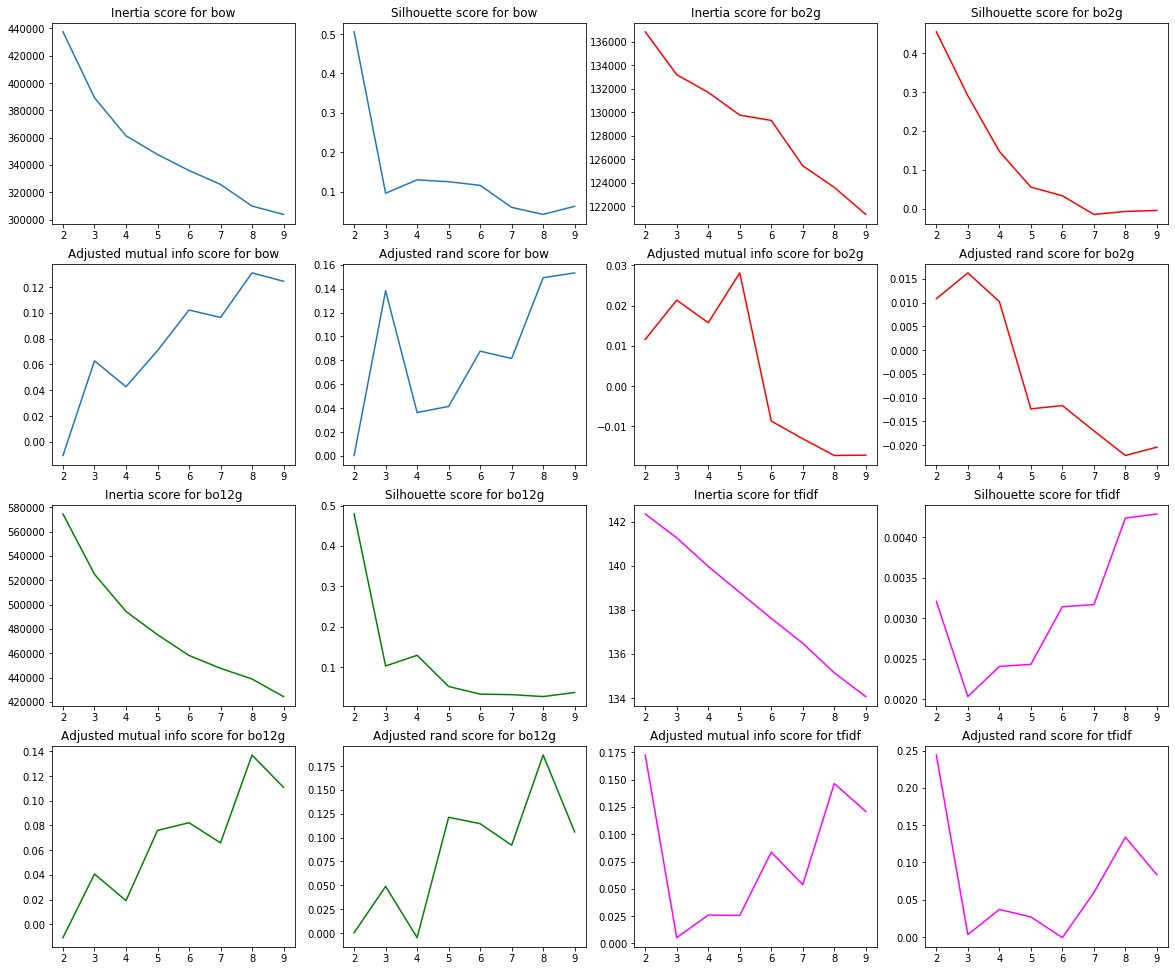

In [24]:
text_representations = [bow, bo2g, bo12g, bow_tfidf_norm]

# Initialise subplots
figure, axis = plt.subplots(4, 4, figsize=(20, 17))

# Plots for bag of words
############################################################
inertia_scores = []
silhouette_scores = []
adj_mi_scores = []
adj_r_scores = []

for clusters in range(2, 10):
    kmeans = KMeans(n_clusters = clusters, random_state=0)
    preds = kmeans.fit_predict(bow)

    inertia_scores.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(bow, preds))
    adj_mi_scores.append(adjusted_mutual_info_score(y_true, preds))
    adj_r_scores.append(adjusted_rand_score(y_true, preds))

axis[0, 0].plot(range(2, 10), inertia_scores)
axis[0, 0].set_title("Inertia score for bow")

axis[0, 1].plot(range(2, 10), silhouette_scores)
axis[0, 1].set_title("Silhouette score for bow")

axis[1, 0].plot(range(2, 10), adj_mi_scores)
axis[1, 0].set_title("Adjusted mutual info score for bow")

axis[1, 1].plot(range(2, 10), adj_r_scores)
axis[1, 1].set_title("Adjusted rand score for bow")


# Plots for bag of bigrams
############################################################
inertia_scores = []
silhouette_scores = []
adj_mi_scores = []
adj_r_scores = []

for clusters in range(2, 10):
    kmeans = KMeans(n_clusters = clusters, random_state=0)
    preds = kmeans.fit_predict(bo2g)

    inertia_scores.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(bo2g, preds))
    adj_mi_scores.append(adjusted_mutual_info_score(y_true, preds))
    adj_r_scores.append(adjusted_rand_score(y_true, preds))
    
axis[0, 2].plot(range(2, 10), inertia_scores, color = 'red')
axis[0, 2].set_title("Inertia score for bo2g")

axis[0, 3].plot(range(2, 10), silhouette_scores, color = 'red')
axis[0, 3].set_title("Silhouette score for bo2g")

axis[1, 2].plot(range(2, 10), adj_mi_scores, color = 'red')
axis[1, 2].set_title("Adjusted mutual info score for bo2g")

axis[1, 3].plot(range(2, 10), adj_r_scores, color = 'red')
axis[1, 3].set_title("Adjusted rand score for bo2g")


# Plots for bag of ngrams
############################################################
inertia_scores = []
silhouette_scores = []
adj_mi_scores = []
adj_r_scores = []

for clusters in range(2, 10):
    kmeans = KMeans(n_clusters = clusters, random_state=0)
    preds = kmeans.fit_predict(bo12g)

    inertia_scores.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(bo12g, preds))
    adj_mi_scores.append(adjusted_mutual_info_score(y_true, preds))
    adj_r_scores.append(adjusted_rand_score(y_true, preds))
    
axis[2, 0].plot(range(2, 10), inertia_scores, color = 'green')
axis[2, 0].set_title("Inertia score for bo12g")

axis[2, 1].plot(range(2, 10), silhouette_scores, color = 'green')
axis[2, 1].set_title("Silhouette score for bo12g")

axis[3, 0].plot(range(2, 10), adj_mi_scores, color = 'green')
axis[3, 0].set_title("Adjusted mutual info score for bo12g")

axis[3, 1].plot(range(2, 10), adj_r_scores, color = 'green')
axis[3, 1].set_title("Adjusted rand score for bo12g")


# Plots for tfidf scores
############################################################
inertia_scores = []
silhouette_scores = []
adj_mi_scores = []
adj_r_scores = []

for clusters in range(2, 10):
    kmeans = KMeans(n_clusters = clusters, random_state=0)
    preds = kmeans.fit_predict(bow_tfidf_norm)

    inertia_scores.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(bow_tfidf_norm, preds))
    adj_mi_scores.append(adjusted_mutual_info_score(y_true, preds))
    adj_r_scores.append(adjusted_rand_score(y_true, preds))
    
axis[2, 2].plot(range(2, 10), inertia_scores, color = 'magenta')
axis[2, 2].set_title("Inertia score for tfidf")

axis[2, 3].plot(range(2, 10), silhouette_scores, color = 'magenta')
axis[2, 3].set_title("Silhouette score for tfidf")

axis[3, 2].plot(range(2, 10), adj_mi_scores, color = 'magenta')
axis[3, 2].set_title("Adjusted mutual info score for tfidf")

axis[3, 3].plot(range(2, 10), adj_r_scores, color = 'magenta')
axis[3, 3].set_title("Adjusted rand score for tfidf")


plt.show()

For each of the representations the inertia score seems to descend as the amount of clusters increases. The same could be said for silhouette, but the tfidf representation is an exception for this case, resulting in high values as the amount of clusters increases. Also noteworthy is the fact that the overal inertia scores for cluster amounts for the tfidf representation is significantly lower than the other representations (Descending from 142 to 134, instead of descending in the thousands).


The adjusted scores differ greatly across each of the representations. They show very sudden peaks and valleys for certain amounts of clusters. The adjusted rand score for the tfidf shows a remarkable peak using the least amount of clusters: 2.

**Demonstrate clusters**

* for each representation choose the optimal number of clusters and repeat the k-means algorithm for that number of clusters
* print the top-10 most important words within each cluster
* print the titles of the movies for each cluster
* explain what you observe and whether results make sense

In [25]:

# For bow 3 clusters has a sudden peak in scores
bow_feature_names = bowvectorizer.get_feature_names()

kmeans1 = KMeans(n_clusters = 3, random_state=0)
kmeans1.fit(bow)

print("Most important words for each cluster using kmeans with the bag of words")
for cluster in kmeans1.cluster_centers_:
    serie = pd.Series(cluster, index = bow_feature_names)
    serie = serie.sort_values(ascending = False)
    print(list(serie.index[0:10]))
print("\n\n")
    

# For bo2g 3 clusters has the highest scores overall
bo2g_feature_names = bo2gvectorizer.get_feature_names()

kmeans2 = KMeans(n_clusters = 3, random_state=0)
kmeans2.fit(bo2g)

print("Most important words for each cluster using kmeans with the bag of bigrams")
for cluster in kmeans2.cluster_centers_:
    serie = pd.Series(cluster, index = bo2g_feature_names)
    serie = serie.sort_values(ascending = False)
    print(list(serie.index[0:10]))
print("\n\n")

    
# For bo12g 8 clusters has a clear peak for both the adjusted scores. The silhouette and inertia scores are fairly low but
# the inertia score has only decreased to 420000 from 580000 (the bottom of the y-axis in the inertia score graphs does not
# represent 0) so the highest overall score is at 8 clusters.
bo12g_feature_names = bo12gvectorizer.get_feature_names()

kmeans3 = KMeans(n_clusters = 8, random_state=0)
kmeans3.fit(bo12g)

print("Most important words for each cluster using kmeans with the bag of ngrams")
for cluster in kmeans3.cluster_centers_:
    serie = pd.Series(cluster, index = bo12g_feature_names)
    serie = serie.sort_values(ascending = False)
    print(list(serie.index[0:10]))
print("\n\n")    



# For tfidf scores 2 clusters, the initial and lowest amount, results in the highest overall scores
tfidf_feature_names = bow_vect.get_feature_names()

kmeans4 = KMeans(n_clusters = 2, random_state=0)
kmeans4.fit(bow_tfidf_norm.toarray())

print("Most important words for each cluster using kmeans with the tfidf scores")
for cluster in kmeans4.cluster_centers_:
    serie = pd.Series(cluster, index = tfidf_feature_names)
    serie = serie.sort_values(ascending = False)
    print(list(serie.index[0:10]))

    

Most important words for each cluster using kmeans with the bag of words
['the', 'to', 'and', 'his', 'of', 'is', 'he', 'in', 'her', 'with']
['the', 'to', 'and', 'is', 'of', 'that', 'he', 'his', 'in', 'her']
['the', 'to', 'and', 'of', 'is', 'his', 'in', 'he', 'that', 'with']



Most important words for each cluster using kmeans with the bag of bigrams
['snow white', 'queen clementianna', 'in the', 'the prince', 'of the', 'to the', 'the dwarfs', 'white is', 'the mirror', 'and the']
['that he', 'he is', 'to be', 'him that', 'to the', 'of the', 'him to', 'says that', 'in the', 'tells him']
['of the', 'in the', 'to the', 'that he', 'and the', 'on the', 'he is', 'at the', 'from the', 'with the']



Most important words for each cluster using kmeans with the bag of ngrams
['the', 'to', 'and', 'of', 'his', 'in', 'is', 'he', 'that', 'with']
['to', 'the', 'he', 'and', 'dave', 'mitch', 'that', 'is', 'him', 'his']
['the', 'to', 'and', 'his', 'of', 'is', 'he', 'in', 'with', 'her']
['the', 'to', 'he

As expected, words with little meaning (such as "the", "to", etc.) are the most important using the bag of words.


Interestingly the bigram shows certain composition of words being very important, while they consist of less important individual words.Those compositions are again overruled in the case using the n-grams, however. The frequency of the standard little meaning words is too great and thus they show as being more important.


The tfidf score shows very different results for its clusters. We find it hard to explain why these exact words are shown as important, as we have not read the scripts ourselves. We find it worthy to not that the tfidf algorithm does not recognize the importance of the words with little meaning, instead focusing on more differing words.
